# <center>Лабораторна робота 2</center>
<center><b>Дмитренко ФБ-04</b></center>


Lab 1: Базові алгоритми навчання без учителя та обробка текстових даних (Scikit-learn lib)

---

### Хід роботи

Використовуємо датасет з першої лаби US Election 2020 конкретніше таблицю president_county_candidate.csv [Kaggle](https://www.kaggle.com/datasets/unanimad/us-election-2020/data?select=president_county_candidate.csv)

# Попередня обробка

## Імпорти, читання, аналіз

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 1) Завантажити дані, вивести назви колонок і розмір датасета

In [95]:
df = pd.read_csv("../lab1/president_county_candidate.csv")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32177 entries, 0 to 32176
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   state        32177 non-null  object
 1   county       32177 non-null  object
 2   candidate    32177 non-null  object
 3   party        32177 non-null  object
 4   total_votes  32177 non-null  int64 
 5   won          32177 non-null  bool  
dtypes: bool(1), int64(1), object(4)
memory usage: 1.3+ MB


In [96]:
# Видалення колонки 'county'
df = df.drop(columns=['county'])

# Оставити тільки двох топ кандидатів, інших помітити як 'other'
top_candidates = df['candidate'].value_counts().nlargest(2).index
mask_candidate = df['candidate'].isin(top_candidates)
df.loc[~mask_candidate, 'candidate'] = 'other'

# Аналогічно для партій (party)
top_parties = df['party'].value_counts().nlargest(2).index
mask_party = df['party'].isin(top_parties)
df.loc[~mask_party, 'party'] = 'other'

# Групування даних по штату, кандидату та партії, підсумовування голосів
df = df.groupby(['state', 'candidate', 'party'])['total_votes'].sum().reset_index()

In [97]:
print("Назви колонок:", df.columns)
print("Розмір датасету:", df.shape)

Назви колонок: Index(['state', 'candidate', 'party', 'total_votes'], dtype='object')
Розмір датасету: (153, 4)


In [98]:
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = df[column].astype('category').cat.codes

### 2) Опрацювати пропуски (по можливості заповнити їх або видалити)

In [99]:
missing_values = df.isnull().sum()
print("Кількість пропусків у колонках:\n", missing_values)

Кількість пропусків у колонках:
 state          0
candidate      0
party          0
total_votes    0
dtype: int64


Як бачу у датасеті немає пропусків, але так як це вже 3й датасет, тому для не числових колонок заповню пропуски найпопулянрішмим значеннями, а для числових значень -- середніми (що не робив, проте хай буде)

In [100]:
for column in df.columns:
    if df[column].dtype == 'object':
        df[column].fillna(df[column].mode()[0], inplace=True)
    else:
        df[column].fillna(df[column].mean(), inplace=True)

### 3) Візуалізувати дані

#### 3.1) Heatmap 

Так як у датасеті є не інтові значення, перетворю їх на int використовуючи .astype('category').cat.codes

In [101]:
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = df[column].astype('category').cat.codes

In [102]:
df.head()

,state,candidate,party,total_votes
0,0,0,1,1441168
1,0,1,0,849648
2,0,2,2,32488
3,1,0,1,189892
4,1,1,0,153405


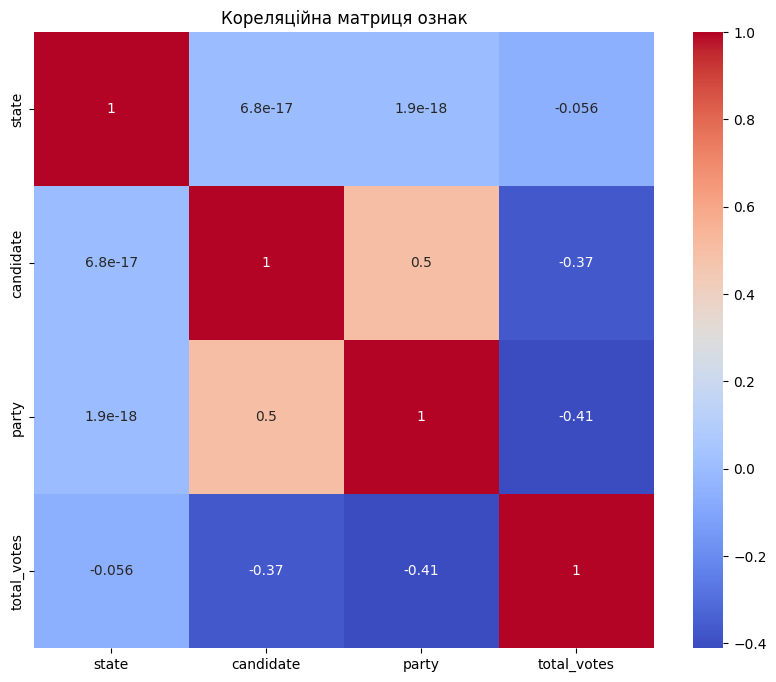

In [103]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Кореляційна матриця ознак')
plt.show()

#### 3.2) Гістограма 

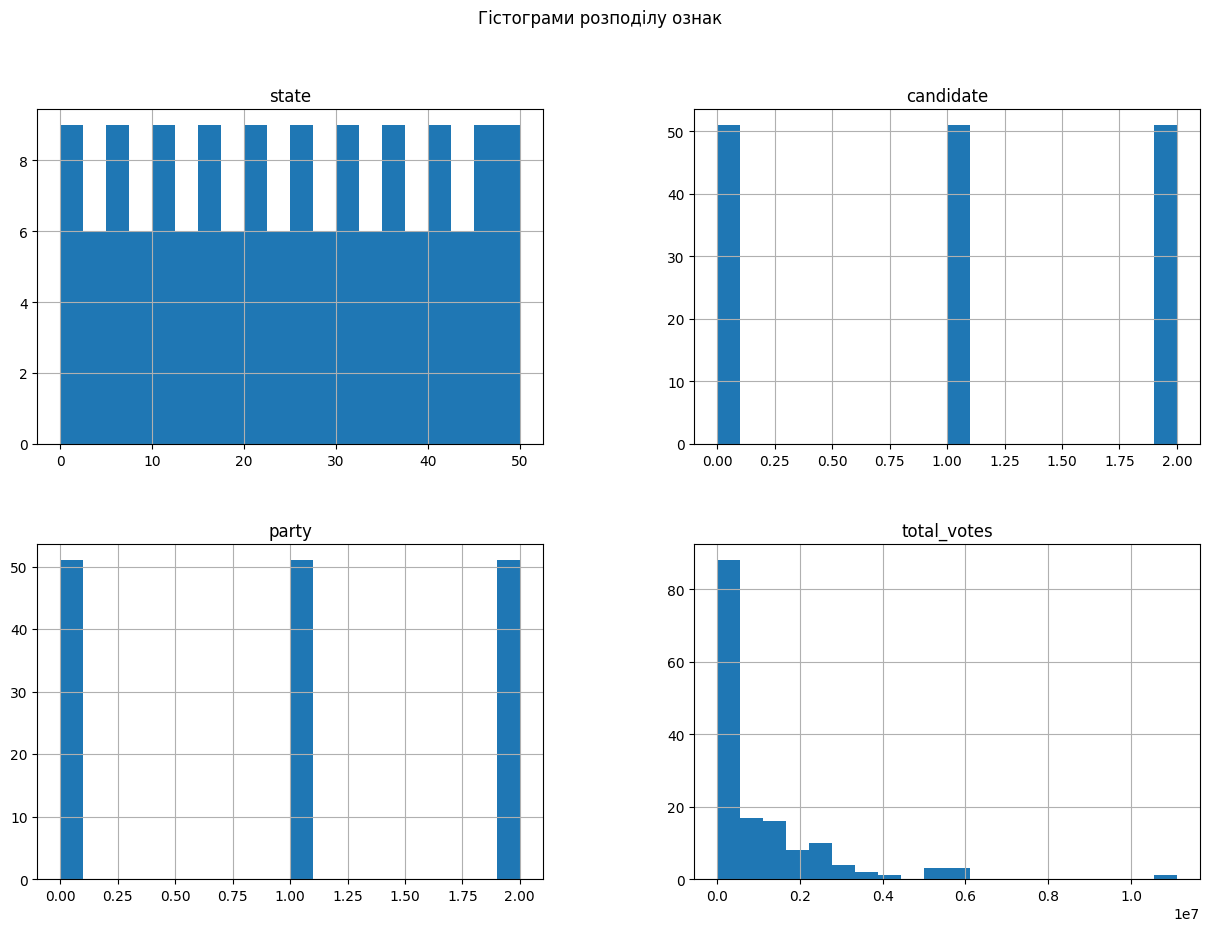

In [104]:
df.hist(figsize=(15, 10), bins=20)
plt.suptitle('Гістограми розподілу ознак')
plt.show()

#### 3.3) Boxplot 

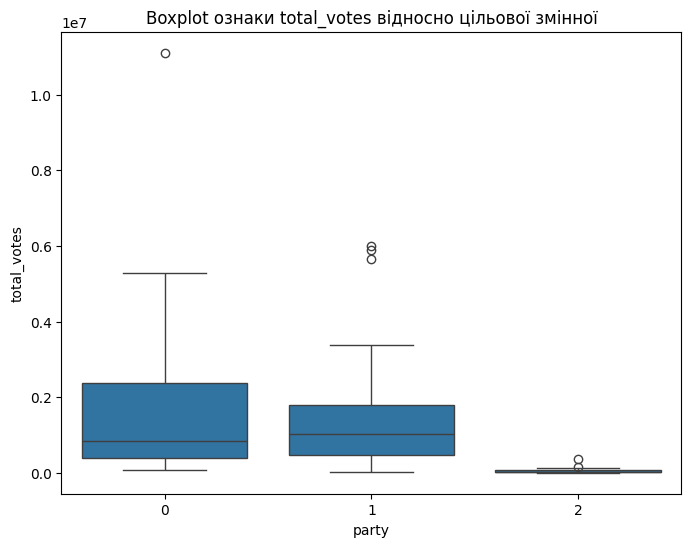

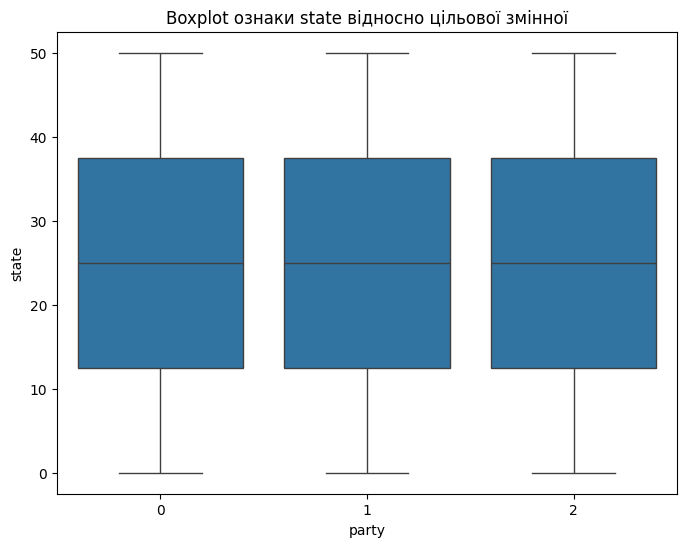

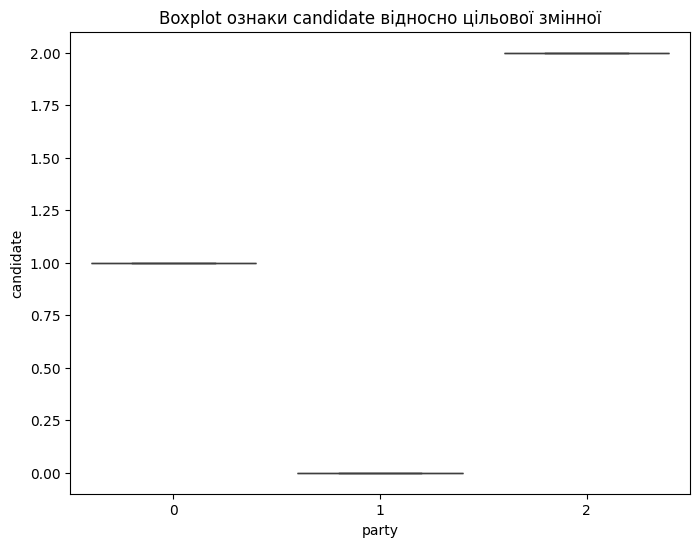

In [105]:
target = 'party'
features = set(df.columns)
features.remove(target)
for feature in features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=target, y=feature, data=df)
    plt.title(f'Boxplot ознаки {feature} відносно цільової змінної')
    plt.show()


# Виконання роботи

### 1) Нормалізувати дані

In [106]:
import tensorflow as tf
from keras.api.models import Sequential
from keras.api.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.api.utils import to_categorical

In [107]:
X = df.drop(columns=[target])
y = df[target]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [109]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## 1. Повнозв'язані нейронні мережі (Fully Connected Feed-Forward Network)

In [110]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')  # Вихідний шар
])


c:\Users\dmytr\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [111]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [112]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6545 - loss: 1.0104 - val_accuracy: 0.7200 - val_loss: 0.9281
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8631 - loss: 0.8804 - val_accuracy: 0.8400 - val_loss: 0.8426
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9004 - loss: 0.7891 - val_accuracy: 0.8400 - val_loss: 0.7713
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9004 - loss: 0.7153 - val_accuracy: 0.8000 - val_loss: 0.7126
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8941 - loss: 0.6561 - val_accuracy: 0.8000 - val_loss: 0.6583
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9243 - loss: 0.5768 - val_accuracy: 0.8000 - val_loss: 0.6155
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9222 - loss: 0.5459 - val_accuracy: 0.8400 - val_loss: 0.5775
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9221 - loss: 0.5122 - val_accuracy: 0.8400 - val_loss: 0.5380
Epoch 9/20
4/4 ━━━

In [113]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Точність на тестових даних: {test_accuracy:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.1408
Точність на тестових даних: 1.00


## 2. Згорткові нейронні мережі (CNN)

In [114]:
import os
import shutil
from sklearn.model_selection import train_test_split

In [115]:
base_dir = 'Pistachio_Image_Dataset/Pistachio_Image_Dataset'

# Папки для тренувальних, валідаційних і тестових даних
output_dirs = {
    'train': 'Pistachio_Image_Dataset/train',
    'val': 'Pistachio_Image_Dataset/val',
    'test': 'Pistachio_Image_Dataset/test',
}

# Створення вихідних папок
for subset, dir_path in output_dirs.items():
    os.makedirs(dir_path, exist_ok=True)


In [116]:
for class_name in ['Kirmizi_Pistachio', 'Siirt_Pistachio']:
    class_dir = os.path.join(base_dir, class_name)
    images = os.listdir(class_dir)

    # Розділення даних
    train_images, temp_images = train_test_split(images, test_size=0.2, random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

    # Копіювання файлів у відповідні папки
    for subset, subset_images in zip(['train', 'val', 'test'], [train_images, val_images, test_images]):
        subset_dir = os.path.join(output_dirs[subset], class_name)
        os.makedirs(subset_dir, exist_ok=True)

        for image in subset_images:
            src_path = os.path.join(class_dir, image)
            dst_path = os.path.join(subset_dir, image)
            shutil.copy(src_path, dst_path)


### 2.1 Навчання з нуля (from scratch)

In [117]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [118]:
# Шлях до тренувальної, валідаційної і тестової папок
train_dir = 'Pistachio_Image_Dataset/train'
val_dir = 'Pistachio_Image_Dataset/val'
test_dir = 'Pistachio_Image_Dataset/test'

In [119]:
# Генератори даних
train_datagen = ImageDataGenerator(rescale=1.0/255)
val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [120]:
# Завантаження даних
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

Found 1717 images belonging to 2 classes.
Found 215 images belonging to 2 classes.
Found 216 images belonging to 2 classes.


### 2.2 Transfer Learning (перенесення навчання)

In [121]:
from keras.api.models import Sequential
from keras.api.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [122]:
# Архітектура моделі
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')  # 2 класи
])

c:\Users\dmytr\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [123]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [124]:
history = model.fit(train_data, epochs=10, validation_data=val_data)

Epoch 1/10


c:\Users\dmytr\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 230ms/step - accuracy: 0.7487 - loss: 0.5490 - val_accuracy: 0.8558 - val_loss: 0.3371
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - accuracy: 0.8501 - loss: 0.3392 - val_accuracy: 0.8698 - val_loss: 0.3240
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.8899 - loss: 0.2678 - val_accuracy: 0.8651 - val_loss: 0.2994
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 0.8964 - loss: 0.2429 - val_accuracy: 0.8651 - val_loss: 0.3045
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.9347 - loss: 0.1800 - val_accuracy: 0.8837 - val_loss: 0.3003
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.9413 - loss: 0.1497 - val_accuracy: 0.8837 - val_loss: 0.3219
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.9553 - loss: 0.1167 - val_accuracy: 0.9116 - val_loss: 0.2793
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.9683 - loss: 0.0807 - val_accuracy: 0.8791 - val

In [125]:
# Оцінка
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Точність на тестових даних (Transfer Learning): {test_accuracy:.2f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.8580 - loss: 0.4167
Точність на тестових даних (Transfer Learning): 0.87


In [126]:
from keras.api.applications import EfficientNetB0
from keras.api.models import Sequential
from keras.api.layers import Dense, GlobalAveragePooling2D

In [127]:
# Завантаження EfficientNet
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Заморожування

In [128]:
# Додавання власних шарів
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')  # 2 класи
])

In [129]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [130]:
history = model.fit(train_data, epochs=5, validation_data=val_data)

Epoch 1/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 179ms/step - accuracy: 0.5399 - loss: 0.7010 - val_accuracy: 0.5721 - val_loss: 0.7013
Epoch 2/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.5727 - loss: 0.6932 - val_accuracy: 0.4279 - val_loss: 0.6938
Epoch 3/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.5434 - loss: 0.6893 - val_accuracy: 0.5721 - val_loss: 0.6828
Epoch 4/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.5587 - loss: 0.6893 - val_accuracy: 0.5721 - val_loss: 0.6845
Epoch 5/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 0.5771 - loss: 0.6843 - val_accuracy: 0.5721 - val_loss: 0.6835


In [131]:
# Оцінка
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Точність на тестових даних (Transfer Learning): {test_accuracy:.2f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.5961 - loss: 0.6784
Точність на тестових даних (Transfer Learning): 0.57


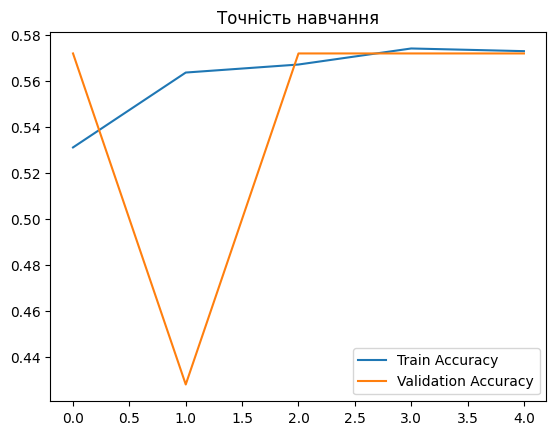

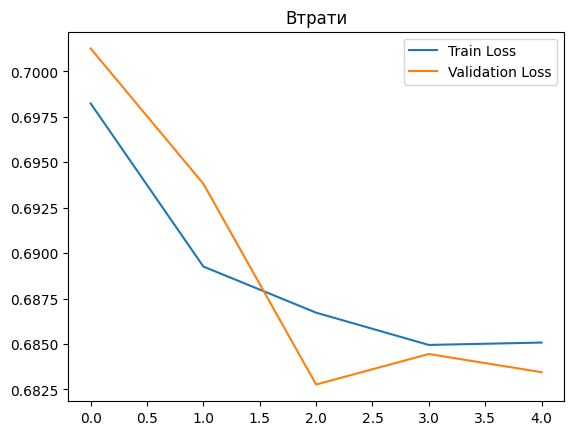

In [132]:
import matplotlib.pyplot as plt

# Точність
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Точність навчання')
plt.show()

# Втрати
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Втрати')
plt.show()


## 3. Рекурентні нейронні мережі (RNN)

In [133]:
import pandas as pd

data = pd.read_csv('../lab2/tweet_emotions.csv')
data.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [134]:
# # Закомментив бо вже завантажено
# import nltk
# nltk.download('stopwords') 

from nltk.corpus import stopwords
import string

stop_words = set(stopwords.words('english'))

# Видалення стоп-слів та передобробка тексту
def preprocess_text(text):
    text = text.lower()  # Зниження регістру
    text = ''.join([char for char in text if char not in string.punctuation])  # Видалення пунктуації
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Видалення стоп-слів
    return text

data['content'] = data['content'].apply(preprocess_text)

In [135]:
texts = data['content'].values
labels = data['sentiment'].values

In [136]:
from sklearn.preprocessing import LabelEncoder

# Перетворення міток у числа
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [137]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.api.preprocessing.sequence import pad_sequences
from keras.api.utils import to_categorical

In [138]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=100)
y = to_categorical(labels)

### 3.1 Навчання з нуля (from scratch)

In [139]:
from keras.api.models import Sequential
from keras.api.layers import Embedding, LSTM, Dense

In [140]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=100),
    LSTM(64),
    Dense(y.shape[1], activation='softmax')
])

c:\Users\dmytr\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [141]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [142]:
history = model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.2803 - loss: 2.0790 - val_accuracy: 0.3573 - val_loss: 1.9387
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.4225 - loss: 1.7309 - val_accuracy: 0.3590 - val_loss: 1.9528
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.4966 - loss: 1.5141 - val_accuracy: 0.3478 - val_loss: 2.0305
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.5813 - loss: 1.2757 - val_accuracy: 0.3105 - val_loss: 2.2467
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.6557 - loss: 1.0574 - val_accuracy: 0.3079 - val_loss: 2.4265
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.7142 - loss: 0.8828 - val_accuracy: 0.2812 - val_loss: 2.7206
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.7580 - loss: 0.7487 - val_accuracy: 0.2889 - val_loss: 2.9955
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.7941 -

### 3.2 Pretrained Word Embeddings

In [151]:
from keras.api.models import Sequential
from keras.api.layers import Embedding, LSTM, Dense, Dropout

In [152]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=100)
y = to_categorical(labels)

In [153]:
model = Sequential([
    Embedding(input_dim=10_000,  # Розмір словника
              output_dim=128,      # Розмірність векторів слів
              input_length=100),  # Довжина послідовності
    LSTM(128, return_sequences=True),
    Dropout(0.5),
    LSTM(64),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')  # Кількість класів
])

In [154]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [155]:
history = model.fit(X, y, batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 46s 43ms/step - accuracy: 0.2484 - loss: 2.1415 - val_accuracy: 0.3631 - val_loss: 1.9371
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 43s 43ms/step - accuracy: 0.3682 - loss: 1.8618 - val_accuracy: 0.3594 - val_loss: 1.9424
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - accuracy: 0.4174 - loss: 1.7384 - val_accuracy: 0.3647 - val_loss: 1.9733
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4700 - loss: 1.6113 - val_accuracy: 0.3460 - val_loss: 2.0262
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 43s 43ms/step - accuracy: 0.5210 - loss: 1.4627 - val_accuracy: 0.3469 - val_loss: 2.1601
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.5514 - loss: 1.3506 - val_accuracy: 0.3331 - val_loss: 2.3290
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.5845 - loss: 1.2502 - val_accuracy: 0.3255 - val_loss: 2.6266
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 43s 43ms/step - accuracy: 0.6221 -

In [157]:
# Оцінка моделі на тестових даних
test_loss, test_accuracy = model.evaluate(X, y)
print(f"Точність на тестових даних: {test_accuracy:.2f}")

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.7287 - loss: 0.8327
Точність на тестових даних: 0.64
